In [1]:
import numpy as np
from numpy.linalg import norm
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from load_data import load_adult
m, n, x, y, sparse_features, not_sparse_features = load_adult()

In [3]:
seed = 777
random.seed(seed)
np.random.seed(seed)

In [4]:
w0 = np.random.random(n)

In [5]:
lambda1 = 1.1
lambda2 = 2.1

g = lambda w: lambda1 * norm(w[sparse_features])**2 + lambda2 * norm(w[not_sparse_features])**2
F = lambda w: np.log(1 + np.exp(-y*x.dot(w))).mean() + g(w)

def g_grad(w):
    grad = np.zeros(n)
    grad[sparse_features] = 2 * lambda1 * w[sparse_features]
    grad[not_sparse_features] = 2 * lambda2 * w[not_sparse_features]
    return grad

F_grad = lambda w: np.multiply(x.T, -y * np.exp(x.dot(w)) / (1 + np.exp(x.dot(w)))).mean(axis=1) + g_grad(w)
F_stoch_grad_batch = lambda w, k_set: np.multiply(x[k_set].T, -y[k_set] * np.exp(x[k_set].dot(w)) / (1 + np.exp(x[k_set].dot(w)))).mean(axis=1) + g_grad(w)

def g_grad_flat(w):
    grad = np.zeros_like(w)
    grad[:, sparse_features] = 2 * lambda1 * w[:, sparse_features]
    grad[:, not_sparse_features] = 2 * lambda2 * w[:, not_sparse_features]
    return grad

F_stoch_grad_batch_flat = lambda w, k_set: np.multiply(x[k_set].T, -y[k_set] * np.exp(w.dot(x[k_set].T))[:, None] / (1 + np.exp(w.dot(x[k_set].T)))[:, None]).mean(axis=2) + g_grad_flat(w)

In [6]:
from utils import estimate_constants
L, mu = estimate_constants(F, F_grad, n)

In [7]:
from local_sgd import local_sgd, local_sgd_prox
points, losses, syncs = local_sgd(F, w0, L, mu, m,
                                  workers=20, syncs_interval=400, maxiter=1400,
                                  stoch_grad_batch=F_stoch_grad_batch, 
                                  stoch_grad_batch_flat=F_stoch_grad_batch_flat)

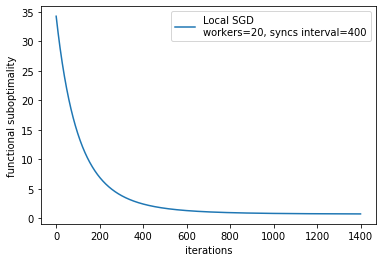

In [8]:
plt.plot(losses, label="Local SGD\nworkers=20, syncs interval=400")
plt.xlabel("iterations")
plt.ylabel("functional suboptimality")
plt.legend()

In [9]:
inner_method = lambda xk, Lk, maxiter, total_iter: local_sgd_prox(
    F, F_grad, xk, L, Lk, mu, m, 
    workers=20, syncs_interval=400, maxiter=maxiter, total_iter=total_iter,
    batch_size=None, stoch_grad_batch=F_stoch_grad_batch, stoch_grad_batch_flat=F_stoch_grad_batch_flat
)

In [10]:
from catalyst import catalyst
catalyst_points, catalyst_losses, catalyst_syncs = catalyst(
    F, F_grad, w0, inner_method, 
    L0=L, Lu=2*L, Ld=0.005*L,
    alpha=1.4, beta=1.2, gamma=1.1, 
    maxiter=6, maxiter_inner=2000
)

outer iter 1
––– inner iter 1 L = 2.5786 (total iters 0)
    34.27788562489146
    28.64223415086261
    24.48120063473728
    21.345442999679126
    18.957121566491313
    17.11897408195072
    15.687345200176225
  > 14.770948159149222
––– inner iter 2 L = 2.1488 (total iters 138)
    34.713168756641835
    28.930259568617224
    24.57096537906019
    21.26852289601298
    18.72724369045411
    16.752831386345832
    15.204707156126853
    13.97722673130797
    13.000539169048634
  > 12.914389647533026
outer iter 2
––– inner iter 1 L = 3.0083 (total iters 302)
    8.573089142326793
    7.275016284820891
    6.321881370814683
    5.611900037429082
    5.074992516121267
    4.667214125741145
  > 4.3519343411055
––– inner iter 2 L = 2.5069 (total iters 424)
    8.363024402102532
    7.089212476651148
    6.141382691152818
    5.427417763920388
    4.879226121129712
    4.4541765261927075
    4.121801163960117
    3.8611597840989464
  > 3.8496340407991645
outer iter 3
––– inner iter 1 L =

In [11]:
flat_catalyst_losses = np.minimum.accumulate(catalyst_losses)

In [12]:
length = min(
    losses.shape[0],
    flat_catalyst_losses.shape[0]
)

In [13]:
f_opt = min(
    losses[:length].min(),
    flat_catalyst_losses[:length].min()
)

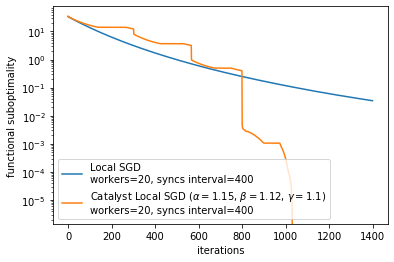

In [14]:
plt.semilogy(losses[:length] - f_opt, label="Local SGD\nworkers=20, syncs interval=400")
plt.semilogy(flat_catalyst_losses[:length]  - f_opt, label="Catalyst Local SGD ($\\alpha=1.15$, $\\beta=1.12$, $\\gamma=1.1$)\nworkers=20, syncs interval=400")
plt.xlabel("iterations")
plt.ylabel("functional suboptimality")
plt.legend()